# Simple LSTM+Attention Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/15/2021**

This notebook does the following actions:
- Model training using the given parameters
- Model selection using Intersection Similarity Score between ground truth helping features and predicted ones
    * Early stopping using Intersection similarity score criteria
- Computes SHAP values and visualizes for a few examples
- Visualizes the train/val/test probability scores from each trained model
- Visualizes the Intersection Similarity Scores for val/test splits
- Finally, after tweaking the parameters, it gets the best model for the given model architecture and dataset

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- LSTM+Attention

Dataset:
- Synthetic-events (Toy Dataset)
- Sequence Length = 30

Requirements:
- Make sure that you have already generated the synthetic toy dataset (train/val/test splits) using [Create_toy_dataset.ipynb](../../data/toy_dataset/Create_toy_dataset.ipynb).

Observations:
- Intersection Similarity is still not a robust way of measuring the performance. It is very aggressive metric
- The feature importance performance is still not as expected. And the performance is lower in predicting the main events as important features
- Providing positive and or negative examples as SHAP background affects the outcome of the SHAP importance scores
- AUC is not a sufficient way of obtaining a robust model
- Multiple runs give different outcomes

Next Steps:
- Once you train different models, save the best one you found
- Do also the same for other models architectures (SimpleLSTM, XGB, etc.) using the separate notebooks
- Finally, go to [02_4_synthetic_shap_jacc.ipynb](02_4_synthetic_shap_jacc.ipynb) to compare to compare the models' performances and shap values usig Jaccard Similarity Index

In [1]:
# pip install nb-black

In [2]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [3]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import lstm_utils as l_utils
import att_lstm_models as lstm_att
import lstm_models as lstm
import shap_jacc_utils as sj_utils

## LSTM+Attention Model Training

### Constants

In [36]:
TEST = 0  # To test on smaller batches
CLIP = False  # Whether to add clipping

model_name = "lstm-att"

nrows = 1e9
min_freq = 1

seq_len = 30

batch_size = 64  # For model training

n_epochs = 10
stop_num = 1

embedding_dim = 8
hidden_dim = 8
nlayers = 1
bidirectional = True
dropout = 0.3
init_type = "zero"  # Possible values: zero/learned
linear_bias = False

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = 500  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = True  # If negative examples are used as background
N_VALID_EXAMPLES = (
    32  # Number of validation examples to be used during model training #TODO
)
N_TEST_EXAMPLES = 128  # Number of test examples #TODO: update here
TEST_POSITIVE_ONLY = True  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = False  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)

# model_save_path = "./output_loss_criteria/{}/{}/models/weights/model_{}.pkl".format(
#     seq_len, model_name, "{}"
# )
# model_save_all_path = "./output_loss_criteria/{}/{}/models/all/model_{}.pkl".format(
#     seq_len, model_name, "{}"
# )
# shap_save_path = "./output_loss_criteria/{}/{}/shap/{}_shap_{}.pkl".format(
#     seq_len, model_name, "{}", "{}"
# )  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))


model_save_path = "./output/final/{}/{}/models/weights/model_{}.pkl".format(
    seq_len, model_name, "{}"
)
model_save_all_path = "./output/final/{}/{}/models/all/model_{}.pkl".format(
    seq_len, model_name, "{}"
)
shap_save_path = "./output/final/{}/{}/shap/{}_shap_{}.pkl".format(
    seq_len, model_name, "{}", "{}"
)  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))


RUN_TRAINING = False  # Whether to run training or visualizing the training results.

In [37]:
if RUN_TRAINING:
    # # SimpleLSTM Model Output Directory

    model_all_save_dir = os.path.dirname(model_save_all_path)
    if os.path.exists(model_all_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(model_all_save_dir)
    os.makedirs(model_all_save_dir)

    model_save_dir = os.path.dirname(model_save_path)
    shap_save_dir = os.path.dirname(shap_save_path)
    if os.path.exists(model_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(model_save_dir)

    if os.path.exists(shap_save_dir):
        # Remove model save directory if exists
        shutil.rmtree(shap_save_dir)
    os.makedirs(model_save_dir)
    os.makedirs(shap_save_dir)

    print(f"New directory created: {model_save_dir}")
    print(f"New directory created: {shap_save_dir}")

print(f"Cuda available: {torch.cuda.is_available()}")
print("Total GPUs:", torch.cuda.device_count())
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True
Total GPUs: 4


### Create Vocab and Build Dataset

In [38]:
train_dataset, vocab = l_utils.build_lstm_dataset(
    train_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=None,
    nrows=nrows,
    rev=rev,
)
valid_dataset, _ = l_utils.build_lstm_dataset(
    valid_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

test_dataset, _ = l_utils.build_lstm_dataset(
    test_data_path,
    min_freq=min_freq,
    uid_colname="patient_id",
    target_colname="label",
    max_len=seq_len,
    target_value=target_value,
    vocab=vocab,
    nrows=nrows,
    rev=rev,
)

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [39]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

### Model Training

In [40]:
if model_name == "lstm":
    model = lstm.SimpleLSTM(
        embedding_dim,
        hidden_dim,
        vocab,
        model_device,
        nlayers=nlayers,
        dropout=dropout,
        init_type=init_type,
        linear_bias=linear_bias,
    )
else:
    model = lstm_att.AttLSTM(
        embedding_dim,
        hidden_dim,
        vocab,
        model_device,
        nlayers=nlayers,
        dropout=dropout,
        init_type=init_type,
        linear_bias=linear_bias,
    )
model = model.cuda()

In [41]:
model

AttLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 8, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
)

In [11]:
# print(
#     "Computing the # of models params and check the accepted ratio of #params/#examples (accepted<=0.1)..."
# )
# # Get the number of trainable parameters
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_examples = 16000
# ratio = float(total_params) / total_examples
# passed = ratio <= 0.1
# print(
#     f"Total Model Params={total_params}, Total Examples={total_examples}, Ratio={ratio}, Test Passed={passed}"
# )

In [42]:
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [43]:
if RUN_TRAINING:
    if EARLY_STOPPING == "intersection_similarity":
        best_valid = float("-inf")
    else:
        best_valid = float("inf")
    worse_valid = 0  # enable early stopping

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss, train_auc = l_utils.epoch_train_lstm(
            model, train_dataloader, optimizer, loss_function, test=TEST, clip=CLIP
        )

        valid_loss, valid_auc = l_utils.epoch_val_lstm(
            model, valid_dataloader, loss_function
        )  # , return_preds=False

        val_shap_path = shap_save_path.format("val", f"{epoch:02}")
        if EARLY_STOPPING == "intersection_similarity":
            print(f"Computing SHAP Intersection Similarity for epoch={epoch}...")
            (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
                model,
                train_dataloader,
                valid_dataloader,
                seq_len,
                val_shap_path,
                save_output=False,
                n_background=N_BACKGROUND,
                background_negative_only=BACKGROUND_NEGATIVE_ONLY,
                n_test=N_VALID_EXAMPLES,
                test_positive_only=TEST_POSITIVE_ONLY,
                is_test_random=IS_TEST_RANDOM,
            )

            valid_sim, _ = sj_utils.get_model_intersection_similarity(
                (features, scores), absolute=SHAP_SCORE_ABSOLUTE
            )
        end_time = time.time()

        epoch_mins, epoch_secs = l_utils.epoch_time(start_time, end_time)

        print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")

        if EARLY_STOPPING == "intersection_similarity":
            if valid_sim > best_valid:
                best_valid = valid_sim
                save_path = model_save_path.format(str(epoch).zfill(2))
                save_all_path = model_save_all_path.format(str(epoch).zfill(2))
                torch.save(model.state_dict(), save_path)
                torch.save(model, save_all_path)
                sj_utils.save_pickle((features, scores, patients), val_shap_path)
                print("Saved Model and SHAP values, epoch {}".format(epoch))
                worse_valid = 0
            else:
                worse_valid += 1
                if worse_valid == stop_num:
                    print("EARLY STOP ------")
                    break
        else:
            if valid_loss < best_valid:
                best_valid = valid_loss
                save_path = model_save_path.format(str(epoch).zfill(2))
                save_all_path = model_save_all_path.format(str(epoch).zfill(2))
                torch.save(model.state_dict(), save_path)
                torch.save(model, save_all_path)
                print("Saved Model, epoch {}".format(epoch))
                worse_valid = 0
            else:
                worse_valid += 1
                if worse_valid == stop_num:
                    print("EARLY STOP ------")
                    break

        scheduler.step()
        sim_message = ""
        if EARLY_STOPPING == "intersection_similarity":
            sim_message = f"| Val Int. Similarity: {valid_sim:.4f}"
        print(
            f"Train Loss: {train_loss:.3f} | Train AUC: {train_auc:.2f} \t Val. Loss: {valid_loss:.3f} |  Val. AUC: {valid_auc:.4f} {sim_message}"
        )

In [44]:
# Get paths of each saved model
models_paths = sj_utils.get_model_paths(model_save_path)
models_paths

['./output/final/30/lstm-att/models/weights/model_00.pkl',
 './output/final/30/lstm-att/models/weights/model_01.pkl',
 './output/final/30/lstm-att/models/weights/model_02.pkl']

## Model Validation and Visualization

In [45]:
def get_positive_scores(labels, scores):
    """Get scores of only positive examples"""
    labels2 = np.array(labels).flatten()
    pos_rows = labels2 == 1
    return scores.flatten()[pos_rows].tolist()

Processing for model model_00.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


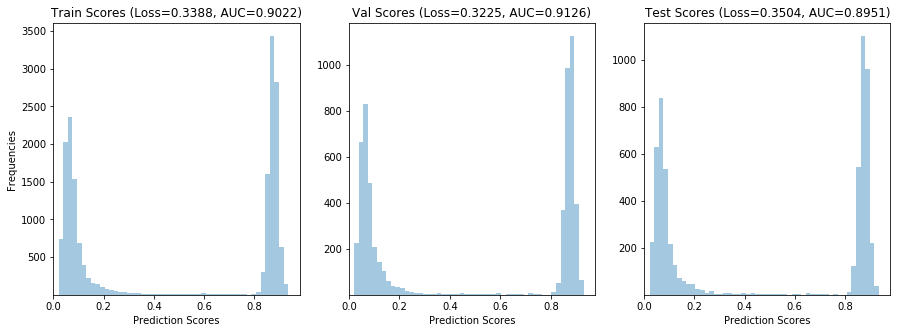

Computing SHAP for 32 positive val examples...


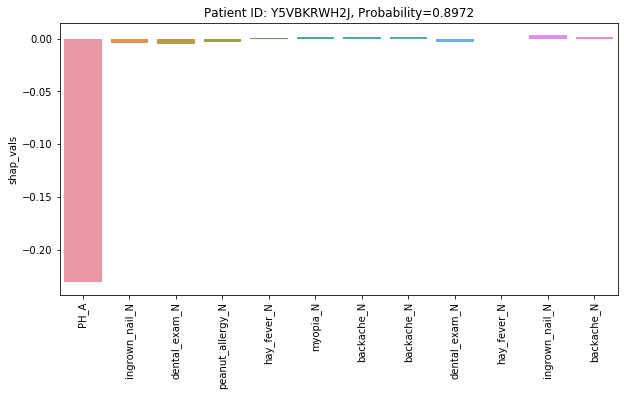

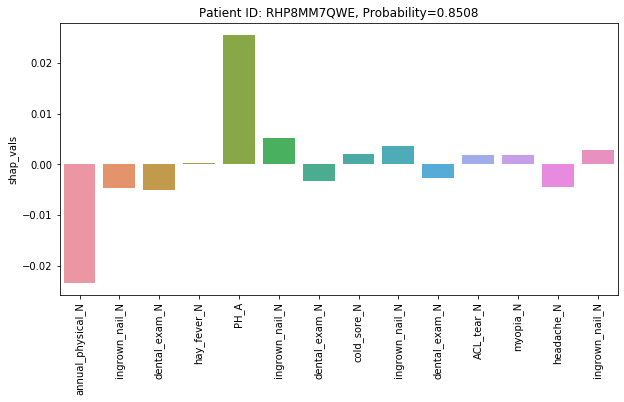

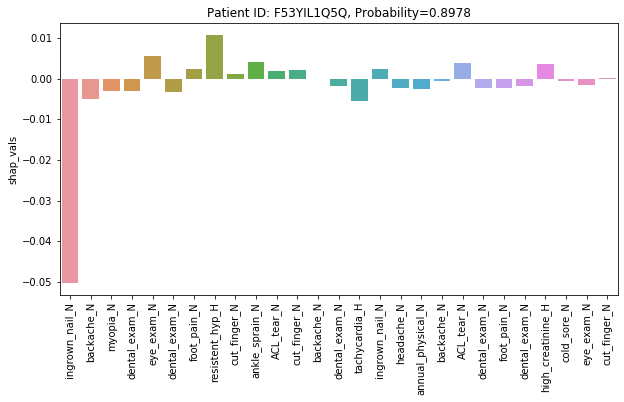

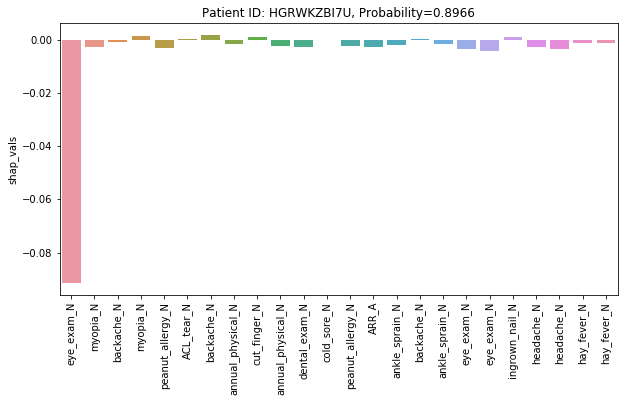

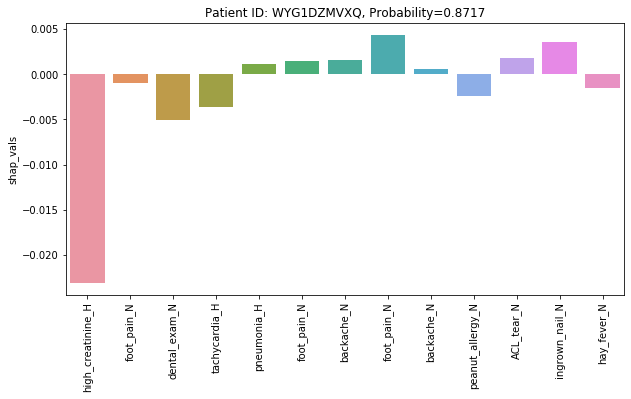

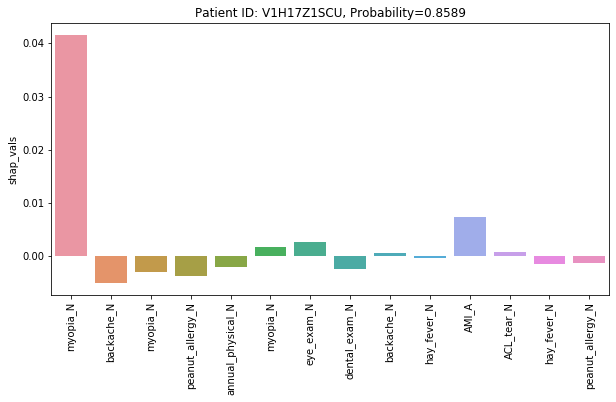

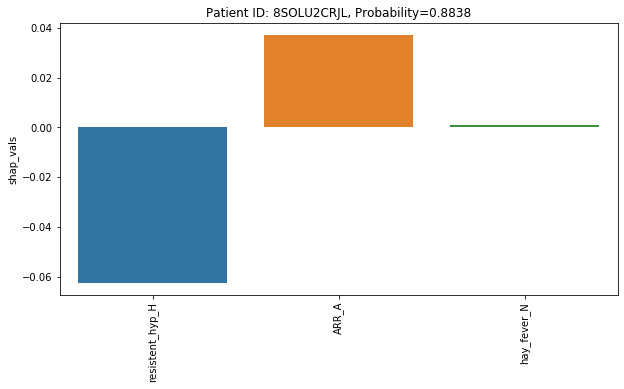

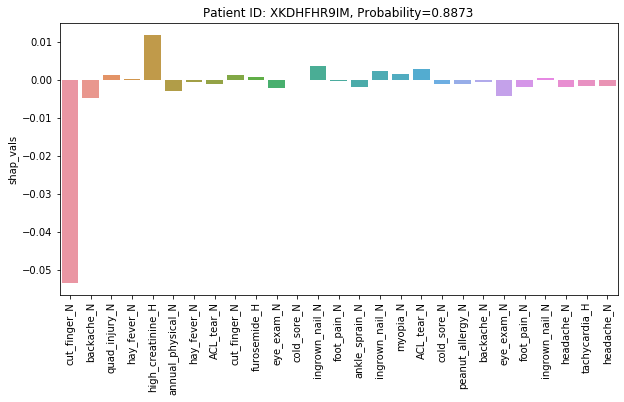

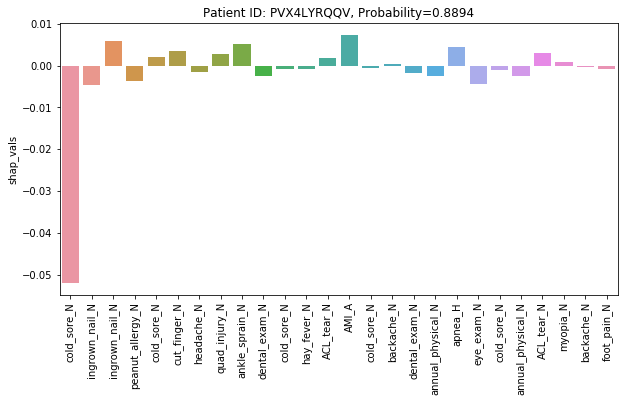

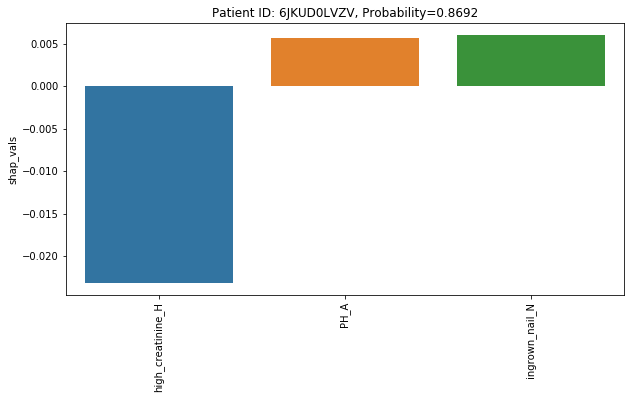

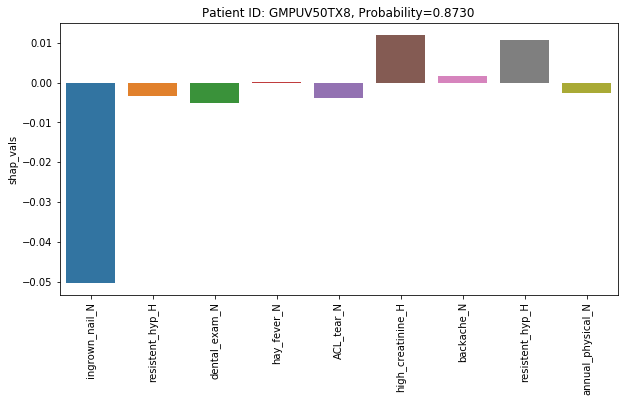

Computing Intersection Similarity...


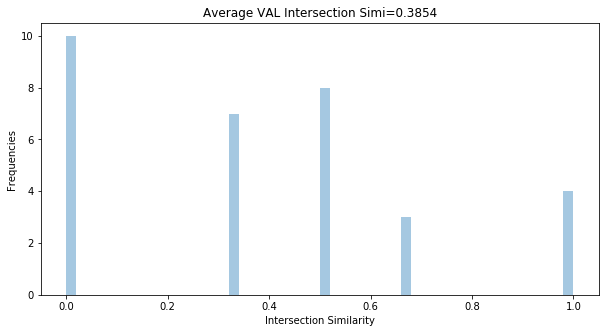

Processing for model model_01.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


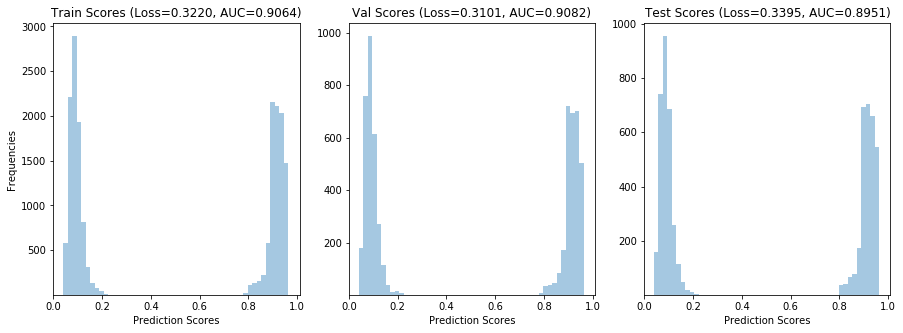

Computing SHAP for 32 positive val examples...


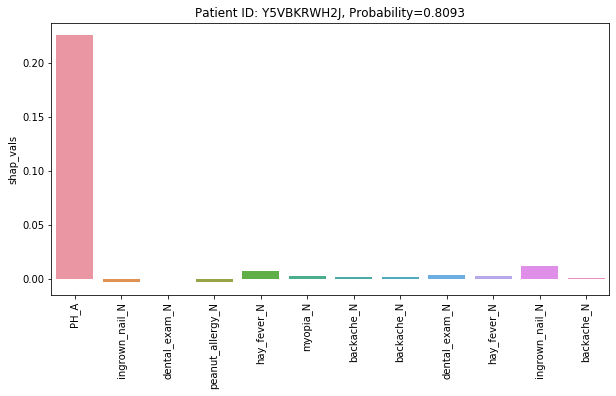

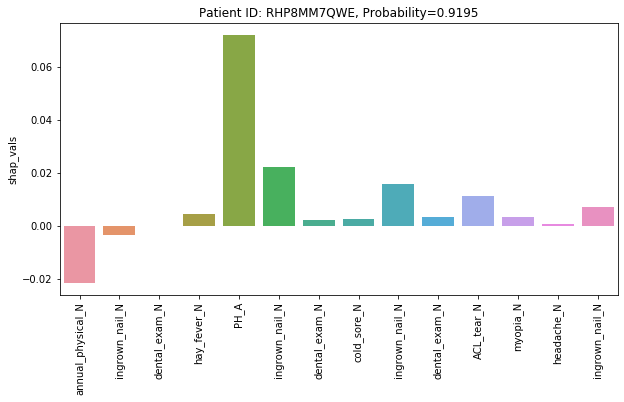

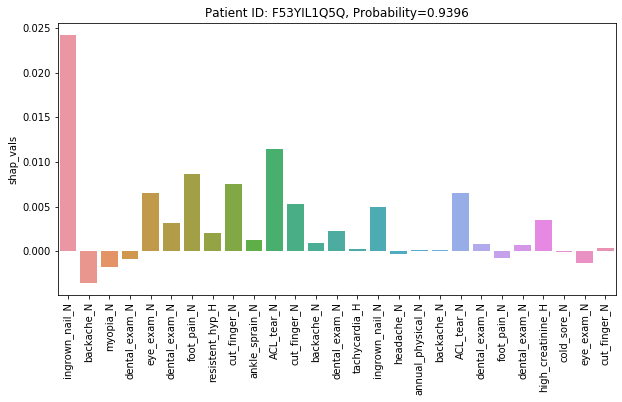

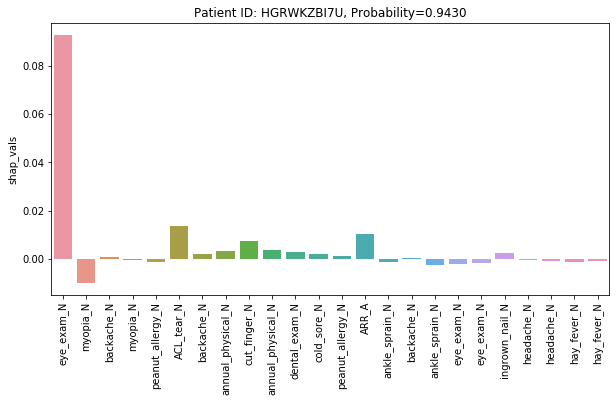

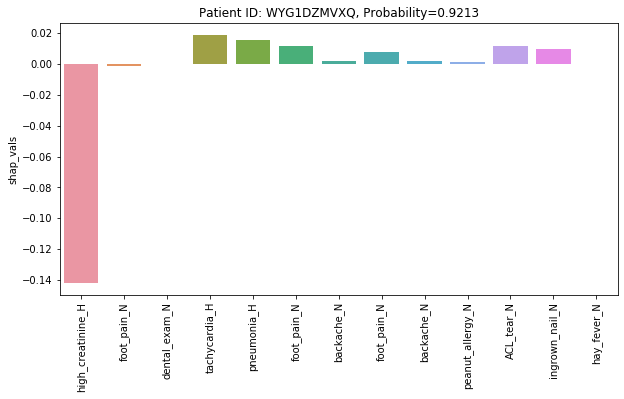

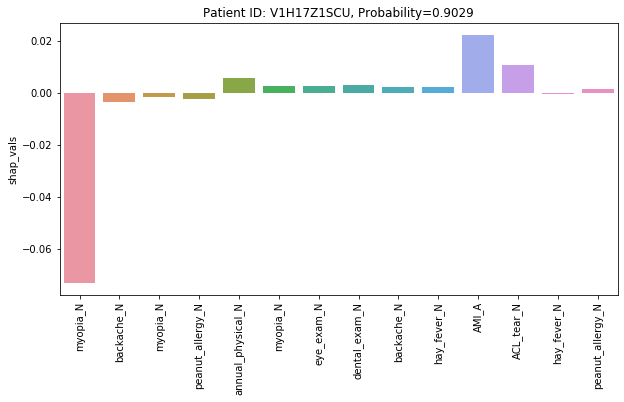

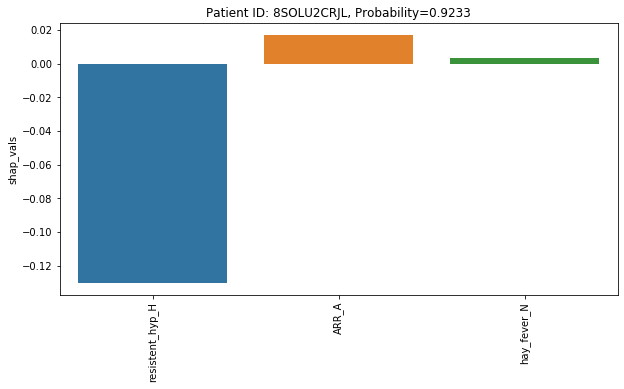

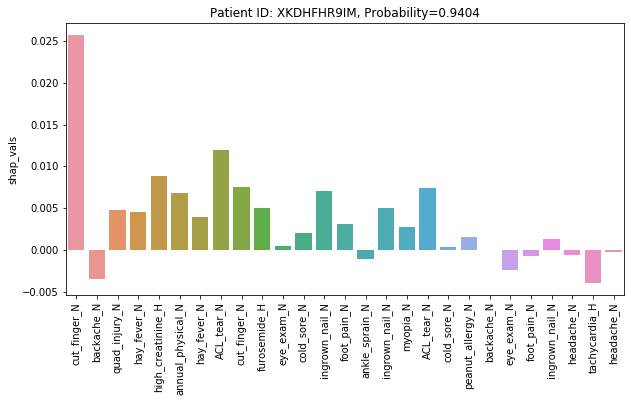

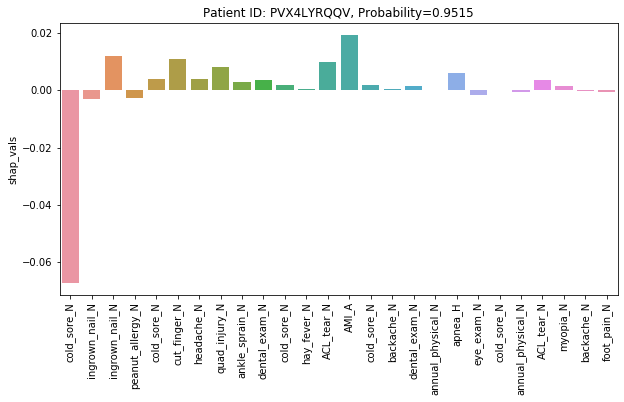

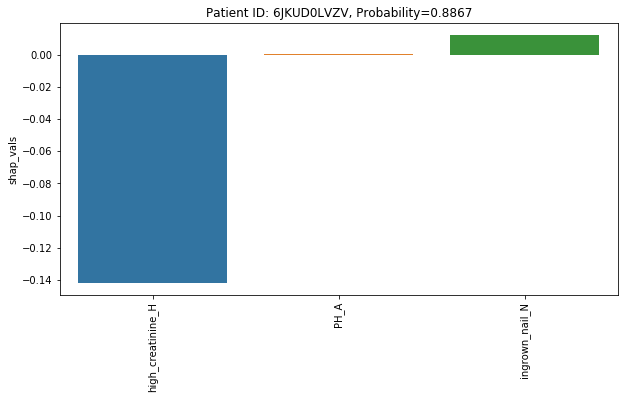

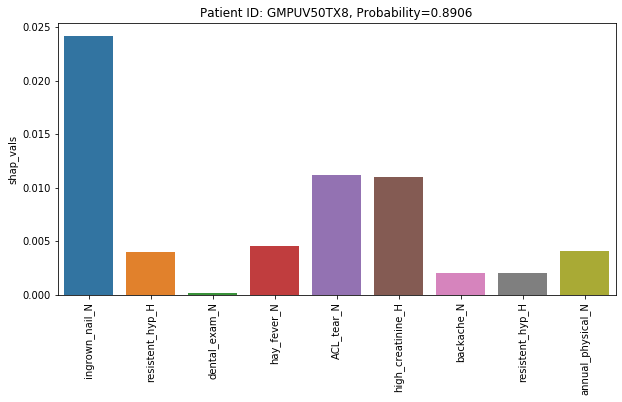

Computing Intersection Similarity...


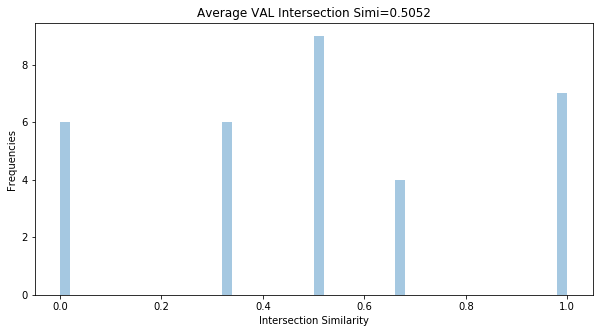

Processing for model model_02.pkl ...
Loading the trained weights...
Computing the models performances for train/val/test splits...
Ploting Histograms of Train/Val/Test Predicted Scores...


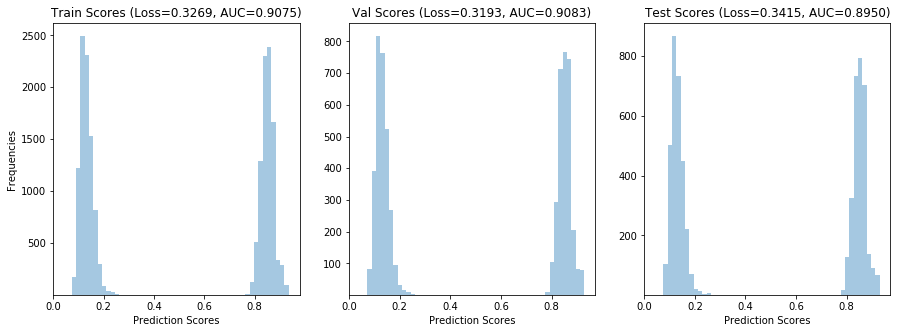

Computing SHAP for 32 positive val examples...


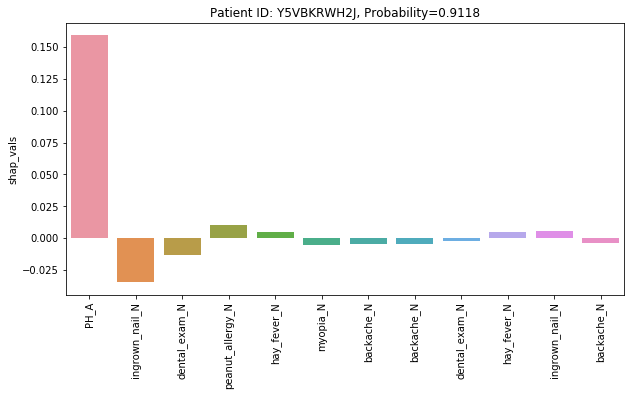

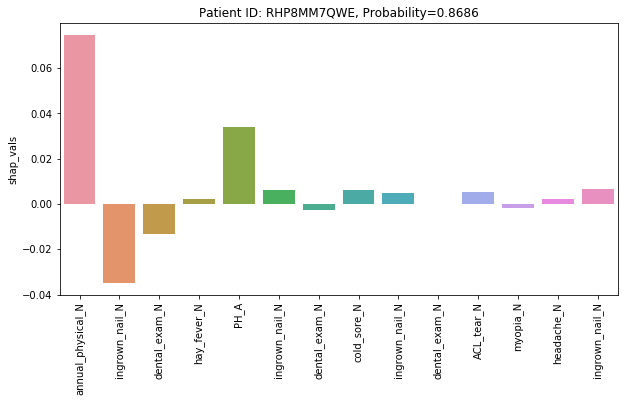

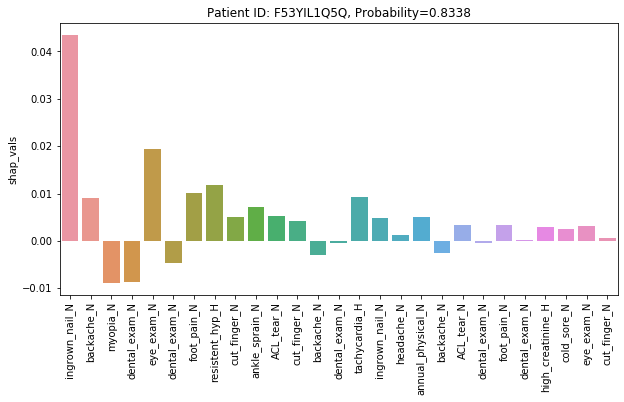

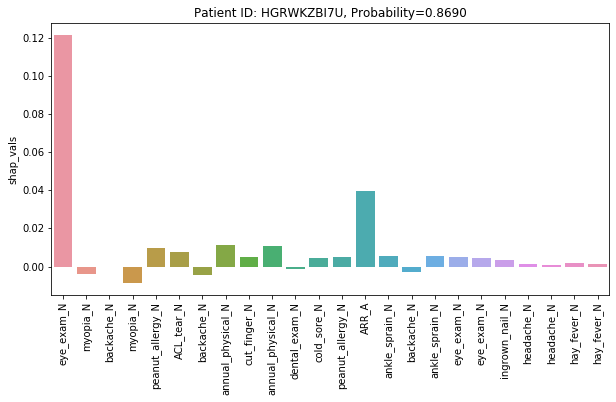

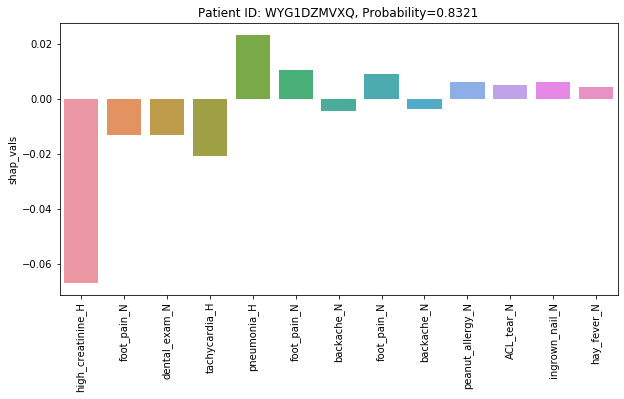

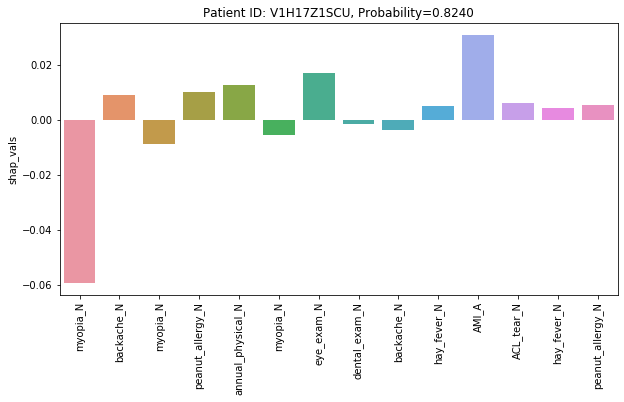

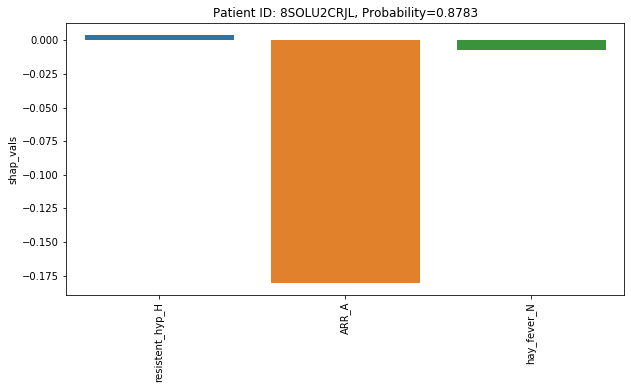

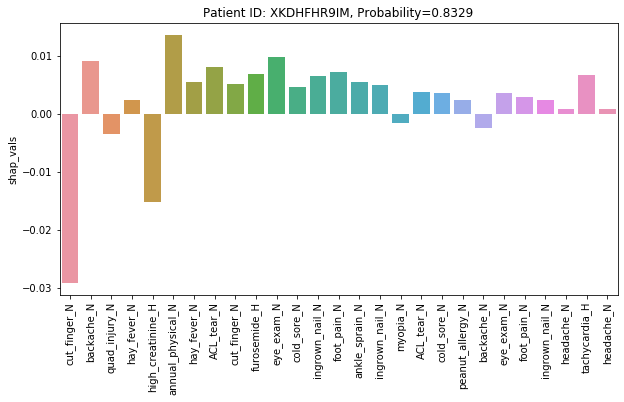

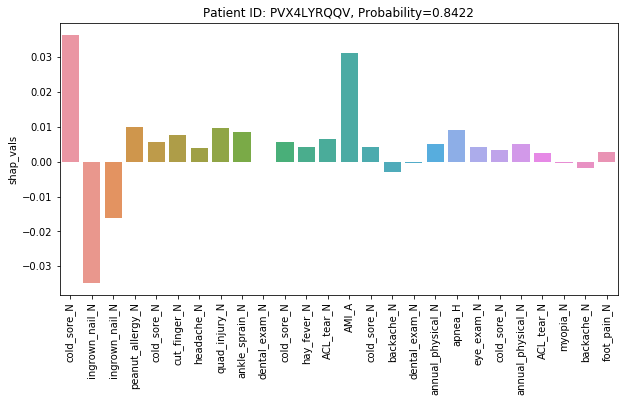

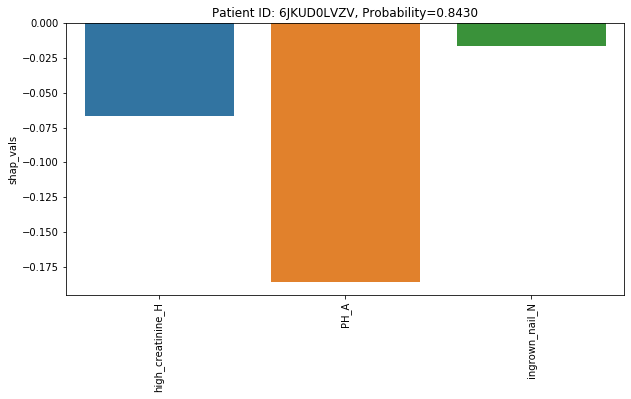

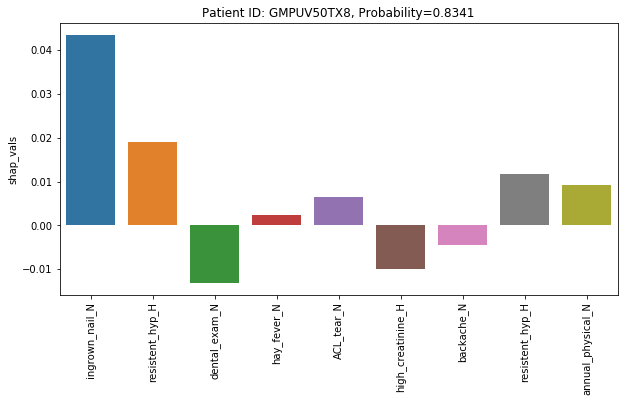

Computing Intersection Similarity...


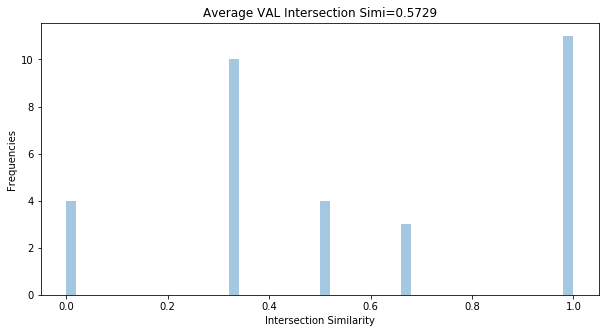

Computing SHAP for 128 positive TEST examples for the final model...


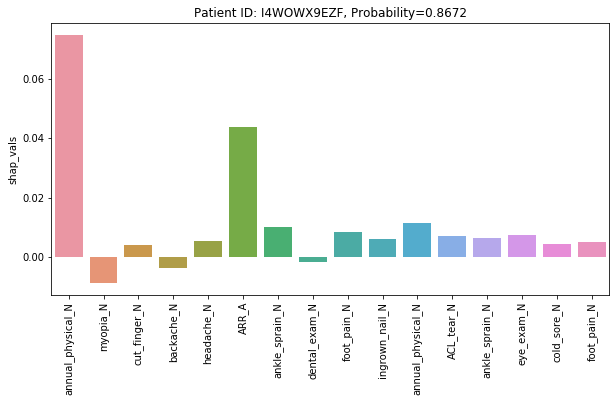

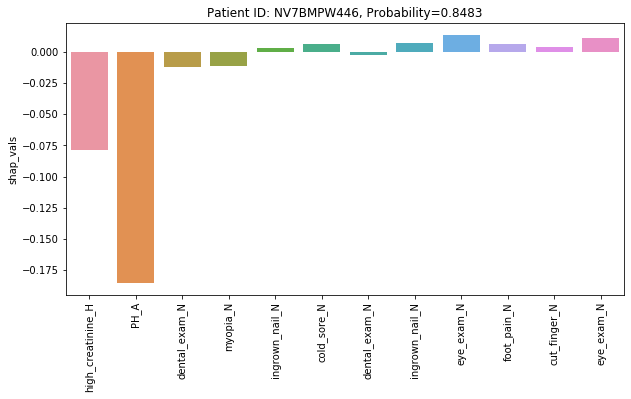

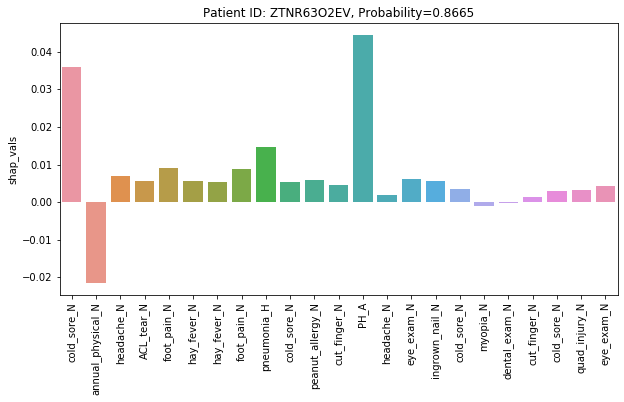

Computing Intersection Similarity...


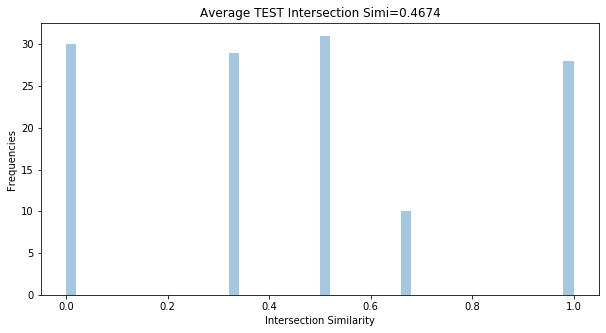

Finally computing and visualizing the global feature importance of the best model....


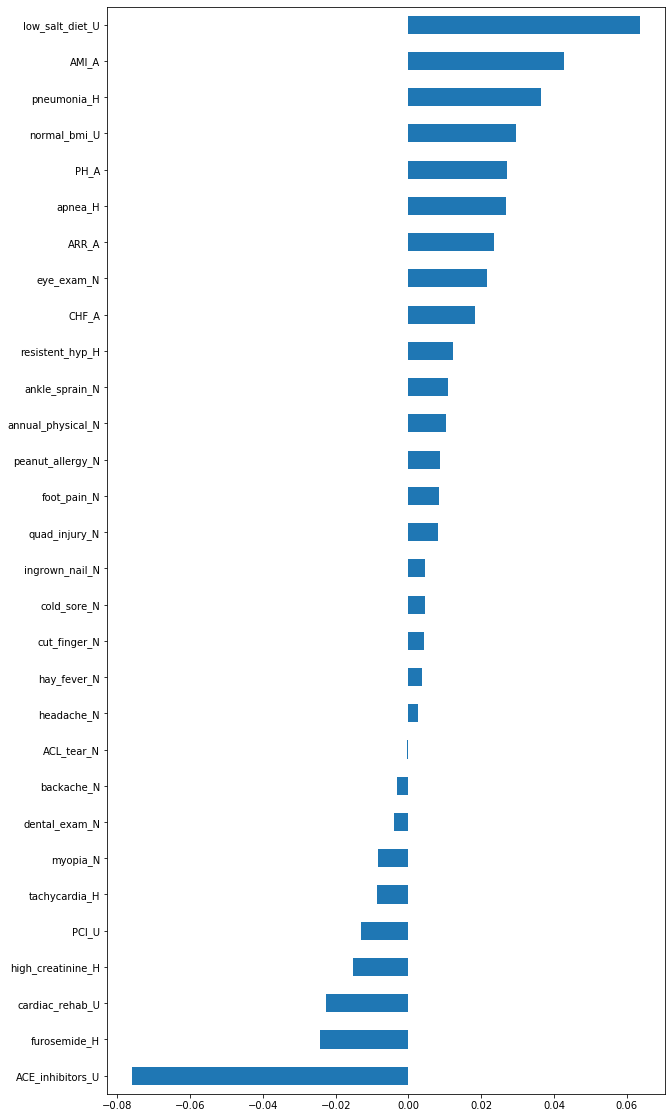

All tasks SUCCESSFULLY completed!


In [46]:
total_models = len(models_paths)
for i, model_path in enumerate(models_paths):
    print(f"Processing for model {os.path.basename(model_path)} ...")
    # Load trained weights
    print("Loading the trained weights...")
    model.load_state_dict(torch.load(model_path))
    ##Get Train/Val/Test Scores
    print("Computing the models performances for train/val/test splits...")
    train_loss, train_auc, train_labels, train_scores = l_utils.epoch_val_lstm(
        model, train_dataloader, loss_function, return_preds=True
    )
    val_loss, val_auc, val_labels, val_scores = l_utils.epoch_val_lstm(
        model, valid_dataloader, loss_function, return_preds=True, test=TEST
    )
    test_loss, test_auc, test_labels, test_scores = l_utils.epoch_val_lstm(
        model, test_dataloader, loss_function, return_preds=True
    )
    print("Ploting Histograms of Train/Val/Test Predicted Scores...")
    _, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 5))
    # Train
    scores = train_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Train Scores (Loss={train_loss:.4f}, AUC={train_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="Frequencies",
        axes=axes,
        axes_idx=0,
    )
    # Val
    scores = val_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Val Scores (Loss={val_loss:.4f}, AUC={val_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="",
        axes=axes,
        axes_idx=1,
    )
    # Test
    scores = test_scores.flatten().tolist()
    axes = sj_utils.plot_histogram(
        scores,
        title=f"Test Scores (Loss={test_loss:.4f}, AUC={test_auc:.4f})",
        xlabel="Prediction Scores",
        ylabel="",
        axes=axes,
        axes_idx=2,
    )
    plt.show()

    print(f"Computing SHAP for {N_VALID_EXAMPLES} positive val examples...")
    epoch = sj_utils.get_epoch_number_from_path(model_path)
    val_shap_path = shap_save_path.format("val", f"{epoch:02}")
    (
        features,
        scores,
        patients,
    ) = sj_utils.load_pickle(val_shap_path)

    val_prob_scores = get_positive_scores(val_labels, val_scores)
    if N_VALID_EXAMPLES is not None:
        num_val = N_VALID_EXAMPLES
    else:
        num_val = len(val_prob_scores)
    n_vis_examples = 0
    for idx in range(num_val):
        if n_vis_examples > 10:  # TODO
            break
        prob_scores1 = val_prob_scores[idx]
        features1 = features[idx]
        scores1 = scores[idx]
        patient_id = patients[idx]
        patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

        if prob_scores1 >= 0.8:
            df_shap = pd.DataFrame(
                np.array([features1, scores1]).T, columns=["events", "shap_vals"]
            )
            df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

            sj_utils.plot_shap_values(
                df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
            )
            n_vis_examples += 1

    print("Computing Intersection Similarity...")
    avg_sim, sim = sj_utils.get_model_intersection_similarity(
        (features, scores), absolute=SHAP_SCORE_ABSOLUTE
    )
    sj_utils.plot_histogram(
        sim,
        title=f"Average VAL Intersection Simi={avg_sim:.4f}",
        xlabel="Intersection Similarity",
        ylabel="Frequencies",
        axes=None,
    )

    # For the best model, get the final performance (test set) (intersection similarity)
    if i == (total_models - 1):
        message = ""
        if N_TEST_EXAMPLES is None:
            message = (
                f"Computing SHAP for ALL positive TEST examples for the final model..."
            )
        else:
            message = f"Computing SHAP for {N_TEST_EXAMPLES} positive TEST examples for the final model..."
        print(message)
        test_shap_path = shap_save_path.format("test", f"{epoch:02}")
        if RUN_TRAINING:
            (features, scores, patients,) = sj_utils.get_lstm_features_and_shap_scores(
                model,
                train_dataloader,
                test_dataloader,
                seq_len,
                test_shap_path,
                save_output=True,
                n_background=N_BACKGROUND,
                background_negative_only=BACKGROUND_NEGATIVE_ONLY,
                n_test=N_TEST_EXAMPLES,
                test_positive_only=TEST_POSITIVE_ONLY,
                is_test_random=IS_TEST_RANDOM,
            )
        else:
            (
                features,
                scores,
                patients,
            ) = sj_utils.load_pickle(test_shap_path)
        test_prob_scores = get_positive_scores(test_labels, test_scores)
        if N_TEST_EXAMPLES is not None:
            num_test = N_TEST_EXAMPLES
        else:
            num_test = len(test_prob_scores)
        n_vis_examples = 0
        for idx in range(num_test):
            if n_vis_examples > 2:
                break
            prob_scores1 = test_prob_scores[idx]
            features1 = features[idx]
            scores1 = scores[idx]
            patient_id = patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T,
                    columns=["events", "shap_vals"],
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                n_vis_examples += 1

        print("Computing Intersection Similarity...")
        avg_sim, sim = sj_utils.get_model_intersection_similarity(
            (features, scores), absolute=SHAP_SCORE_ABSOLUTE
        )
        sj_utils.plot_histogram(
            sim,
            title=f"Average TEST Intersection Simi={avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )

        print(
            "Finally computing and visualizing the global feature importance of the best model...."
        )
        feat_importance = sj_utils.get_global_feature_importance(
            features, scores, absolute=SHAP_SCORE_ABSOLUTE
        )
        sj_utils.plot_global_feature_importance(feat_importance)
        print("All tasks SUCCESSFULLY completed!")

    print("=" * 100)